In [1]:
# 1. Import thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout
from keras.optimizers import Adam, Adamax, Ftrl
from keras.callbacks import EarlyStopping

2024-06-09 08:01:54.792855: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 08:01:54.792964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 08:01:54.927062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_excel("/kaggle/input/eth-data/processed_data.xlsx")
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
ftrl_optimizer = Ftrl(learning_rate = 0.001, l1_regularization_strength=0.0, l2_regularization_strength=0.0)

In [9]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(100, return_sequences=True, input_shape=(time_step, 1)))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100, return_sequences=True))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(GRU(100))  # Increased number of units
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1))  # Output layer
model.compile(loss='mean_squared_error', optimizer=ftrl_optimizer)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 100, 100)       │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100, 100)       │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,201 (594.54 KB)

 Trainable params: 152,201 (594.54 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_val,yval),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.1662 - val_loss: 0.2757
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1758 - val_loss: 0.2725
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1629 - val_loss: 0.2700
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1674 - val_loss: 0.2678
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1738 - val_loss: 0.2660
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1644 - val_loss: 0.2643
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1613 - val_loss: 0.2628
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1582 - val_loss: 0.2614
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1599 - val_loss: 0.2601
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1500 - val_loss: 0.2589
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1622 - val_loss: 0.2577
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
valid_rmse = np.sqrt(mean_squared_error(yval, y_pred_val))
test_rmse = np.sqrt(mean_squared_error(ytest, y_pred))

# Calculate MSE
valid_mse = mean_squared_error(yval, y_pred_val)
test_mse = mean_squared_error(ytest, y_pred)

# Calculate MAE
valid_mae = mean_absolute_error(yval, y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)

# Calculate MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100

# Print evaluation metrics
print(f"Validation RMSE: {valid_rmse}")
print(f"Testing RMSE: {test_rmse}")
print(f"Validation MSE: {valid_mse}")
print(f"Testing MSE: {test_mse}")
print(f"Validation MAE: {valid_mae}")
print(f"Testing MAE: {test_mae}")
print(f"Validation MAPE: {valid_mape}%")
print(f"Testing MAPE: {test_mape}%")

Validation RMSE: 467.57457129418293
Testing RMSE: 467.77857284509616
Validation MSE: 218625.97972093898
Testing MSE: 218816.79321299493
Validation MAE: 467.57454565882796
Testing MAE: 467.7785699440287
Validation MAPE: 100911.84352304351%
Testing MAPE: 158385.10324500952%


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.60840427 0.59790777 0.61295149 0.63854157 0.65264274 0.66657997
 0.69660977 0.68729693 0.70710649 0.70434052 0.7190048  0.74866357
 0.73261135 0.78881953 0.80054378 0.80431139 0.8092796  0.8019998
 0.84140269 0.82307402 0.8286433  0.80241398 0.77095152 0.72578276
 0.75121155 0.72474585 0.6480962  0.72376913 0.71942968 0.68554606
 0.68616416 0.71127167 0.74025132 0.73953263 0.72094495 0.73395759
 0.72343159 0.72261019 0.75236934 0.72199032 0.67353848 0.68081434
 0.68477024 0.68239753 0.6899055  0.7110288  0.76245899 0.72201867
 0.73022326 0.72203664 0.66626424 0.61561329 0.64795235 0.63618127
 0.63263341 0.61132255 0.62861498 0.62717947 0.64809812 0.6458991
 0.65746217 0.66134595 0.64430739 0.64786039 0.64225689 0.66820689
 0.67046287 0.66039249 0.61718439 0.60814422 0.61205443 0.63659425
 0.63957936 0.6437637  0.62791332 0.61596994 0.6089679  0.62223251
 0.59538368 0.59576884 0.59940596 0.60379983 0.58929341 0.62245289
 0.60290043 0.63458992 0.6407221  0.62985191 0.75577

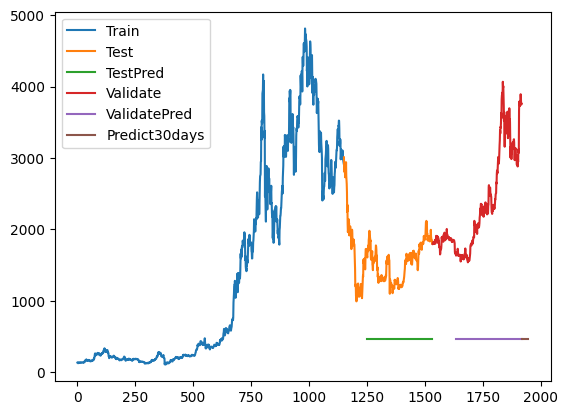

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','TestPred','Validate','ValidatePred','Predict30days'])
plt.show()